In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *
print(torch.cuda.is_available())

False


### Bivariate Normal Data Generation

In [132]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 5],
    2: [3, 1],
    3: [1.5, 6]
}
std = 0.3
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

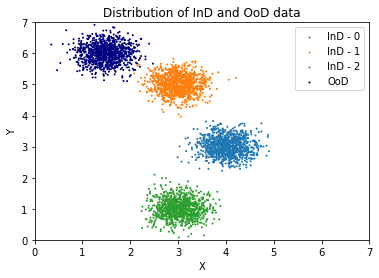

In [133]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

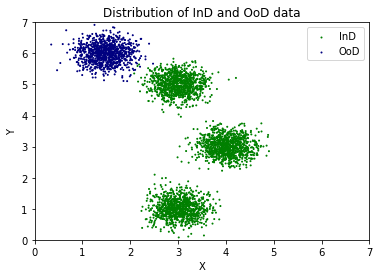

In [134]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [ ]:
from tqdm import tqdm
from simulation import classifier_training, DSIM_SINGLE, GSIM_SINGLE
D = DSIM(64)
# D = DSIM_SINGLE()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

### WOOD Training

#### Check sampled points

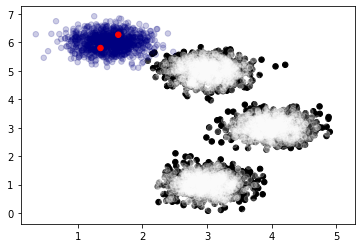

In [186]:
n_ood = 2
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
plt.scatter(IND_X[:,0], IND_X[:,1], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='red', label="OoD", sizes=[30]*len(OOD_X), alpha=1)

#### Training

In [187]:
from simulation import *
D_WOOD = DSIM(64).to(DEVICE)
# D_WOOD = DSIM_SINGLE()
# OOD data preparation
ood_bsz = 4
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

100%|██████████| 256/256 [01:11<00:00,  3.57it/s]


In [ ]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

### OOD GAN Training

In [191]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(64).to(DEVICE)
G_GAN = GSIM(64).to(DEVICE)
# D_GAN = DSIM_SINGLE(64)
# G_GAN = GSIM_SINGLE(64)
# OOD data preparation
ood_bsz = 4
bsz_tri = 32
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 1, 1
scaling = 0.01
d_step_ratio, g_step_ratio = 2, 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist, scaling,\
                    d_step_ratio, g_step_ratio, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=50)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/256 [00:00<?, ?it/s]

Step: 0    | D:  1.1118 | CE:  1.2712 | W_OoD:  0.1624 | W_z:  0.3017 | G: -0.0030 | W_z:  0.3021 | dist: 3.6902


  0%|          | 1/256 [00:10<46:16, 10.89s/it]

Epoch  # 1 | Val accuracy: 0.0159


  2%|▏         | 4/256 [00:42<44:27, 10.59s/it]

Step: 2    | D:  0.5968 | CE:  0.9810 | W_OoD:  0.3873 | W_z:  0.3051 | G: -0.0030 | W_z:  0.3043 | dist: 3.7198


  2%|▏         | 6/256 [01:05<46:00, 11.04s/it]

Epoch  # 6 | Val accuracy: 0.9776


  3%|▎         | 8/256 [01:27<45:35, 11.03s/it]

Step: 4    | D:  0.4748 | CE:  0.8605 | W_OoD:  0.3881 | W_z:  0.2454 | G: -0.0025 | W_z:  0.2451 | dist: 3.5991


  4%|▍         | 11/256 [02:00<45:11, 11.07s/it]

Epoch  # 11 | Val accuracy: 0.9969


  5%|▍         | 12/256 [02:11<45:18, 11.14s/it]

Step: 6    | D:  0.3668 | CE:  0.7515 | W_OoD:  0.3868 | W_z:  0.2060 | G: -0.0021 | W_z:  0.2061 | dist: 3.2990


  6%|▋         | 16/256 [02:55<44:00, 11.00s/it]

Epoch  # 16 | Val accuracy: 0.9913
Step: 8    | D:  0.2777 | CE:  0.6611 | W_OoD:  0.3854 | W_z:  0.2060 | G: -0.0020 | W_z:  0.2031 | dist: 2.8511


  8%|▊         | 20/256 [03:43<45:41, 11.61s/it]

Step: 10   | D:  0.1877 | CE:  0.5698 | W_OoD:  0.3840 | W_z:  0.2014 | G: -0.0020 | W_z:  0.2033 | dist: 2.4224


  8%|▊         | 21/256 [03:54<45:14, 11.55s/it]

Epoch  # 21 | Val accuracy: 0.9897


 10%|▉         | 25/256 [04:42<45:16, 11.76s/it]

Step: 0    | D:  0.1525 | CE:  0.5332 | W_OoD:  0.3830 | W_z:  0.2279 | G: -0.0022 | W_z:  0.2186 | dist: 1.9789


 10%|█         | 26/256 [04:54<45:19, 11.82s/it]

Epoch  # 26 | Val accuracy: 0.9877


 11%|█▏        | 29/256 [05:29<44:41, 11.81s/it]

Step: 2    | D:  0.0904 | CE:  0.4684 | W_OoD:  0.3813 | W_z:  0.3245 | G: -0.0032 | W_z:  0.3242 | dist: 1.2044


 12%|█▏        | 31/256 [05:52<44:14, 11.80s/it]

Epoch  # 31 | Val accuracy: 0.9967


 13%|█▎        | 33/256 [06:18<45:18, 12.19s/it]

Step: 4    | D:  0.0261 | CE:  0.4033 | W_OoD:  0.3809 | W_z:  0.3623 | G: -0.0036 | W_z:  0.3576 | dist: 0.9775


 14%|█▍        | 36/256 [06:52<42:52, 11.69s/it]

Epoch  # 36 | Val accuracy: 0.9976


 14%|█▍        | 37/256 [07:04<42:55, 11.76s/it]

Step: 6    | D:  0.0061 | CE:  0.3817 | W_OoD:  0.3791 | W_z:  0.3521 | G: -0.0034 | W_z:  0.3448 | dist: 1.0641


 16%|█▌        | 41/256 [07:49<40:19, 11.25s/it]

Epoch  # 41 | Val accuracy: 0.9981
Step: 8    | D: -0.0581 | CE:  0.3175 | W_OoD:  0.3790 | W_z:  0.3489 | G: -0.0034 | W_z:  0.3413 | dist: 1.0389


 18%|█▊        | 45/256 [08:35<39:25, 11.21s/it]

Step: 10   | D: -0.0890 | CE:  0.2852 | W_OoD:  0.3778 | W_z:  0.3615 | G: -0.0036 | W_z:  0.3561 | dist: 1.1128


 18%|█▊        | 46/256 [08:46<39:51, 11.39s/it]

Epoch  # 46 | Val accuracy: 0.999


 20%|█▉        | 50/256 [09:32<38:56, 11.34s/it]

Step: 0    | D: -0.1240 | CE:  0.2493 | W_OoD:  0.3768 | W_z:  0.3496 | G: -0.0035 | W_z:  0.3504 | dist: 1.2489


 20%|█▉        | 51/256 [09:43<38:50, 11.37s/it]

Epoch  # 51 | Val accuracy: 0.9975


 21%|██        | 54/256 [10:18<38:58, 11.58s/it]

Step: 2    | D: -0.1486 | CE:  0.2249 | W_OoD:  0.3768 | W_z:  0.3357 | G: -0.0033 | W_z:  0.3323 | dist: 1.2876


 22%|██▏       | 56/256 [10:42<39:30, 11.85s/it]

Epoch  # 56 | Val accuracy: 0.9966


 23%|██▎       | 58/256 [11:03<36:49, 11.16s/it]

Step: 4    | D: -0.1791 | CE:  0.1937 | W_OoD:  0.3759 | W_z:  0.3177 | G: -0.0031 | W_z:  0.3113 | dist: 1.2375


 24%|██▍       | 61/256 [11:38<36:54, 11.36s/it]

Epoch  # 61 | Val accuracy: 0.9984


 24%|██▍       | 62/256 [11:49<36:20, 11.24s/it]

Step: 6    | D: -0.2113 | CE:  0.1609 | W_OoD:  0.3754 | W_z:  0.3132 | G: -0.0031 | W_z:  0.3106 | dist: 1.5898


 26%|██▌       | 66/256 [12:35<36:09, 11.42s/it]

Epoch  # 66 | Val accuracy: 0.9967
Step: 8    | D: -0.2068 | CE:  0.1654 | W_OoD:  0.3757 | W_z:  0.3480 | G: -0.0034 | W_z:  0.3408 | dist: 1.0791


 27%|██▋       | 70/256 [13:20<34:33, 11.15s/it]

Step: 10   | D: -0.2505 | CE:  0.1222 | W_OoD:  0.3750 | W_z:  0.2281 | G: -0.0022 | W_z:  0.2231 | dist: 1.0738


 28%|██▊       | 71/256 [13:32<35:08, 11.40s/it]

Epoch  # 71 | Val accuracy: 0.999


 29%|██▉       | 75/256 [14:19<35:14, 11.68s/it]

Step: 0    | D: -0.2447 | CE:  0.1266 | W_OoD:  0.3747 | W_z:  0.3396 | G: -0.0033 | W_z:  0.3314 | dist: 1.4639


 30%|██▉       | 76/256 [14:31<34:54, 11.64s/it]

Epoch  # 76 | Val accuracy: 0.999


 31%|███       | 79/256 [15:04<32:55, 11.16s/it]

Step: 2    | D: -0.2629 | CE:  0.1087 | W_OoD:  0.3744 | W_z:  0.2763 | G: -0.0027 | W_z:  0.2701 | dist: 1.6208


 32%|███▏      | 81/256 [15:25<31:54, 10.94s/it]

Epoch  # 81 | Val accuracy: 0.9954


 32%|███▏      | 83/256 [15:48<32:22, 11.23s/it]

Step: 4    | D: -0.2628 | CE:  0.1084 | W_OoD:  0.3745 | W_z:  0.3360 | G: -0.0034 | W_z:  0.3417 | dist: 1.0843


 34%|███▎      | 86/256 [16:19<29:40, 10.47s/it]

Epoch  # 86 | Val accuracy: 0.9974


 34%|███▍      | 87/256 [16:28<28:42, 10.20s/it]

Step: 6    | D: -0.2823 | CE:  0.0898 | W_OoD:  0.3741 | W_z:  0.2022 | G: -0.0020 | W_z:  0.2013 | dist: 1.1392


 36%|███▌      | 91/256 [17:07<26:44,  9.72s/it]

Epoch  # 91 | Val accuracy: 0.9982
Step: 8    | D: -0.2908 | CE:  0.0819 | W_OoD:  0.3745 | W_z:  0.1808 | G: -0.0018 | W_z:  0.1800 | dist: 1.2542


 37%|███▋      | 95/256 [17:45<25:42,  9.58s/it]

Step: 10   | D: -0.2891 | CE:  0.0828 | W_OoD:  0.3751 | W_z:  0.3185 | G: -0.0031 | W_z:  0.3108 | dist: 1.6673


 38%|███▊      | 96/256 [17:54<25:37,  9.61s/it]

Epoch  # 96 | Val accuracy: 0.996


 39%|███▉      | 100/256 [18:33<25:11,  9.69s/it]

Step: 0    | D: -0.2992 | CE:  0.0733 | W_OoD:  0.3750 | W_z:  0.2398 | G: -0.0024 | W_z:  0.2426 | dist: 1.5694


 39%|███▉      | 101/256 [18:43<24:54,  9.64s/it]

Epoch  # 101 | Val accuracy: 0.9951


 41%|████      | 104/256 [19:11<24:21,  9.62s/it]

Step: 2    | D: -0.3153 | CE:  0.0581 | W_OoD:  0.3749 | W_z:  0.1524 | G: -0.0014 | W_z:  0.1438 | dist: 1.4360


 41%|████▏     | 106/256 [19:30<23:53,  9.56s/it]

Epoch  # 106 | Val accuracy: 0.9984


 42%|████▏     | 108/256 [19:50<23:36,  9.57s/it]

Step: 4    | D: -0.2905 | CE:  0.0817 | W_OoD:  0.3746 | W_z:  0.2491 | G: -0.0024 | W_z:  0.2393 | dist: 1.6815


 43%|████▎     | 111/256 [20:19<23:13,  9.61s/it]

Epoch  # 111 | Val accuracy: 0.9982


 44%|████▍     | 112/256 [20:28<22:58,  9.57s/it]

Step: 6    | D: -0.3118 | CE:  0.0623 | W_OoD:  0.3755 | W_z:  0.1415 | G: -0.0015 | W_z:  0.1479 | dist: 1.5790


 45%|████▌     | 116/256 [21:09<24:09, 10.35s/it]

Epoch  # 116 | Val accuracy: 0.9938
Step: 8    | D: -0.3012 | CE:  0.0717 | W_OoD:  0.3755 | W_z:  0.2583 | G: -0.0027 | W_z:  0.2684 | dist: 1.1703


 47%|████▋     | 120/256 [21:52<24:16, 10.71s/it]

Step: 10   | D: -0.3149 | CE:  0.0583 | W_OoD:  0.3754 | W_z:  0.2252 | G: -0.0022 | W_z:  0.2238 | dist: 0.9964


 47%|████▋     | 121/256 [22:03<23:59, 10.66s/it]

Epoch  # 121 | Val accuracy: 0.9977


 49%|████▉     | 125/256 [22:47<23:58, 10.98s/it]

Step: 0    | D: -0.3247 | CE:  0.0492 | W_OoD:  0.3749 | W_z:  0.1074 | G: -0.0010 | W_z:  0.1001 | dist: 1.1422


 49%|████▉     | 126/256 [22:59<24:13, 11.18s/it]

Epoch  # 126 | Val accuracy: 0.998


 50%|█████     | 129/256 [23:33<23:45, 11.22s/it]

Step: 2    | D: -0.3261 | CE:  0.0474 | W_OoD:  0.3766 | W_z:  0.3111 | G: -0.0032 | W_z:  0.3195 | dist: 1.4678


 51%|█████     | 130/256 [23:44<23:43, 11.30s/it]

### PLOT

In [189]:
from simulation import plot_heatmap
n_ind, n_ood = 25, 25
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)

#### Plot Naive Classifier

torch.Size([10000, 3])
0.99: 0.0


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

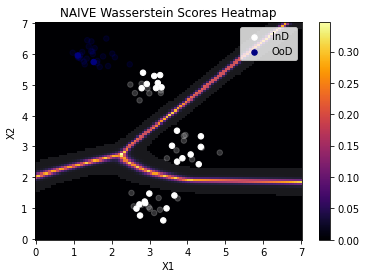

In [179]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D, "NAIVE", ind_idx, ood_idx, 100)

#### Plot WOOD

torch.Size([10000, 3])
0.99: 0.9990000128746033


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

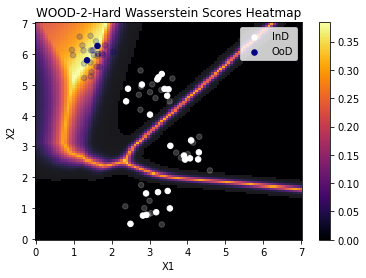

In [190]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_WOOD, "WOOD-2-Hard", ind_idx, ood_idx, m=100)

In [ ]:
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto',cmap='inferno', alpha=1)
cbar = plt.colorbar(ticks=list(np.arange(0.05, 0.4, 0.05)) + [threshold], orientation='vertical')
str_label = [f"{x:.2f}" for x in list(np.round(np.arange(0.05, 0.4, 0.05), 2))] + ['T']
cbar.ax.set_yticklabels(str_label) 

#### Plot GAN

torch.Size([10000, 3])
0.99: 0.9990000128746033


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

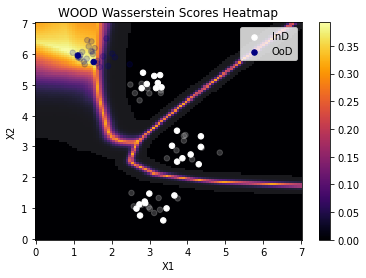

In [175]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_GAN, "OOD-GAN-2-Hard-New", ind_idx, ood_idx, m=100)

torch.Size([160000, 3])
0.99: 1.0


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

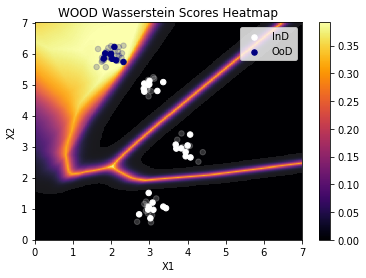

In [116]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_GAN, "OOD-GAN", ind_idx, ood_idx, m=400)

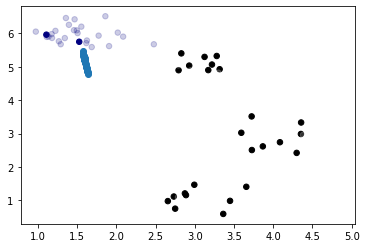

In [177]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Distributional Shift

In [163]:
z_ind = torch.softmax(D_WOOD(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
# print(z.shape)
s_ind = ood_wass_loss(z_ind)
# print(s.shape)
# print(threshold)
z_ood = torch.softmax(D_WOOD(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
# print(z_ood.shape)
s_ood = ood_wass_loss(z_ood)

(array([ 20.,  24.,  18.,  17.,  13.,  17.,  21.,  22., 132., 716.]),
 array([3.80396843e-04, 3.85786667e-02, 7.67769367e-02, 1.14975199e-01,
        1.53173476e-01, 1.91371739e-01, 2.29570001e-01, 2.67768264e-01,
        3.05966556e-01, 3.44164819e-01, 3.82363081e-01]),
 <BarContainer object of 10 artists>)

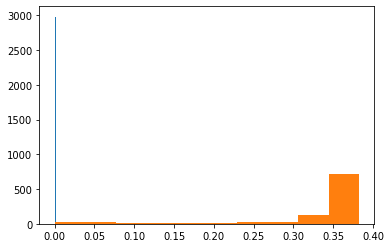

In [164]:
plt.hist(s_ind)
plt.hist(s_ood)

In [170]:
z_ind = torch.softmax(D_GAN(torch.tensor(IND_X, dtype=torch.float32)), dim=-1)
# print(z.shape)
s_ind = ood_wass_loss(z_ind)
# print(s.shape)
# print(threshold)
z_ood = torch.softmax(D_GAN(torch.tensor(OOD_X, dtype=torch.float32)), dim=-1)
# print(z_ood.shape)
s_ood = ood_wass_loss(z_ood)

(array([  4.,   4.,  10.,   7.,  17.,  18.,  41.,  63., 369., 467.]),
 array([0.00625272, 0.04489585, 0.08353899, 0.12218212, 0.16082525,
        0.19946839, 0.23811151, 0.27675465, 0.31539777, 0.35404092,
        0.39268404]),
 <BarContainer object of 10 artists>)

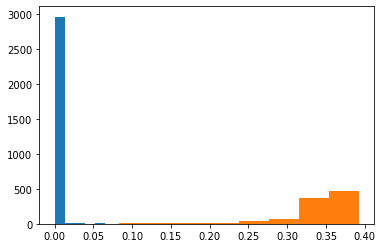

In [171]:
plt.hist(s_ind)
plt.hist(s_ood)

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')